In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from mpl_toolkits.mplot3d import Axes3D

In [2]:
import tensorflow

In [5]:
data = pd.read_csv('DNEdited_weekly_rigs_and_oil_price.csv')

d_time = data['Date'] #time
d_rigs = data['Rigs_Count'] #rigs count column, y, index: 0
d_price_WTI = data['WTI_Oil_Price'] #price column, x, index: 1
d_price_Brent = data['Brent_Oil_Price']

data.set_index('Date',inplace = True)

train = data.iloc[100:700,[0,2]]
test = data.iloc[0:100,[0,2]]
train = pd.DataFrame(train)
test = pd.DataFrame(test)

train.set_index('WTI_Oil_Price',inplace = True)
test.set_index('WTI_Oil_Price',inplace = True)

In [6]:
data.head()
#train.head()


,WTI_Oil_Price,Brent_Oil_Price,Rigs_Count
Date,,,
8/28/2020,42.93,45.26,254
8/21/2020,42.73,44.79,254
8/14/2020,42.08,44.54,244
8/7/2020,41.57,44.36,247
7/31/2020,40.69,43.22,251


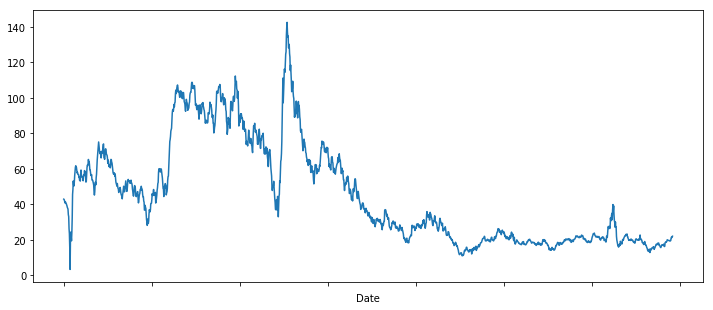

In [7]:
data['WTI_Oil_Price'].plot(figsize=(12,5))

C:\Users\thuyd\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Date'>

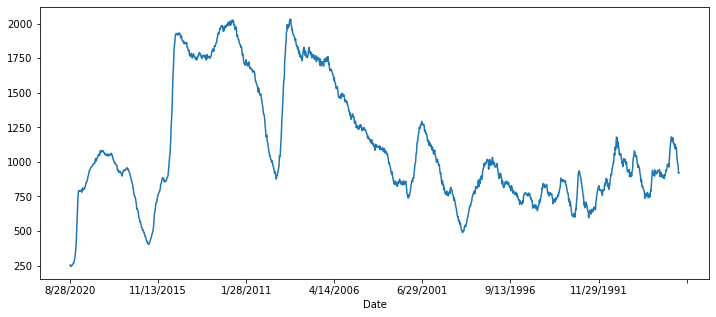

In [129]:
data['Rigs_Count'].plot(figsize=(12,5))

In [130]:
#Axes3D.scatter(d_price_WTI, d_rigs, zs=0, zdir='z', s=20, c=None, depthshade=True)

# d_time = data['Date'] #time
# d_rigs = data['Rigs_Count'] #rigs count column, y, index: 0
# d_price_WTI = data['WTI_Oil_Price'] #price column, x, index: 1
# d_price_Brent

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()#this is a must
scaler.fit(train)#scaler only takes dataframe intead of series

C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [9]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

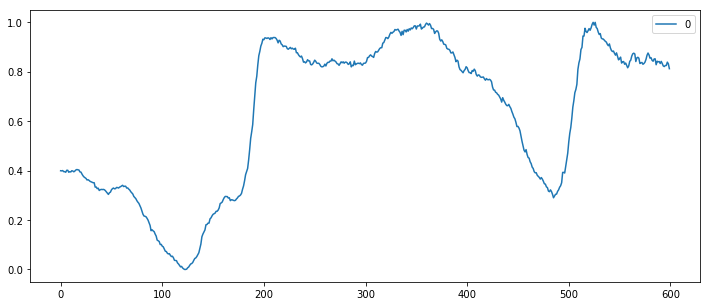

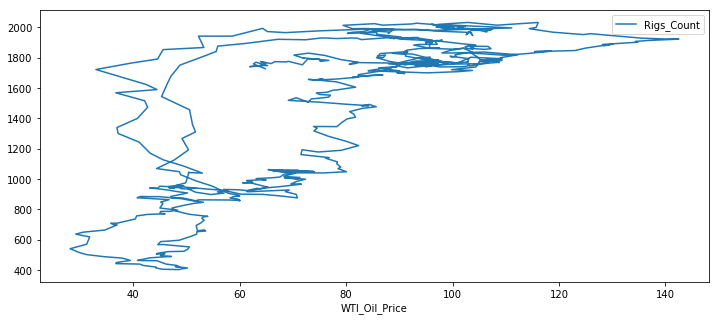

In [10]:
df_scaled_train = pd.DataFrame(scaled_train)
df_scaled_train.plot(figsize=(12,5))
train.plot(figsize=(12,5))

In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator #what is this

Using TensorFlow backend.


In [12]:
# define generator, equally spaced data rows
n_input = 20
n_features = 1
#batch size too large will overfit
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [13]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.3995083  0.39889367 0.40012293 0.39582053 0.39582053 0.39336202
 0.40135218 0.40135218 0.39336202 0.39582053 0.39459127 0.3995083
 0.39827904 0.3952059  0.39827904 0.40258144 0.40442532 0.40319607
 0.40258144 0.39459127]
Predict this y: 
 [[0.39397664]]


In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [19]:
n_input = 50
n_features = 1
#batch size too large will overfit
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [20]:
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences = True, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))

model.add(LSTM(150, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(150, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(150))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50, 150)           91200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 150)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50, 150)           180600    
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 150)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 150)           180600    
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 150)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 150)              

In [22]:
model.fit_generator(train_generator,epochs=5)

Epoch 1/5
550/550 [==============================] - 27s 49ms/step - loss: 0.0240
Epoch 2/5
550/550 [==============================] - 26s 47ms/step - loss: 0.0088
Epoch 3/5
550/550 [==============================] - 26s 47ms/step - loss: 0.0074
Epoch 4/5
550/550 [==============================] - 27s 49ms/step - loss: 0.0051
Epoch 5/5
550/550 [==============================] - 27s 48ms/step - loss: 0.0056


In [23]:
model.history.history.keys()

dict_keys(['loss'])

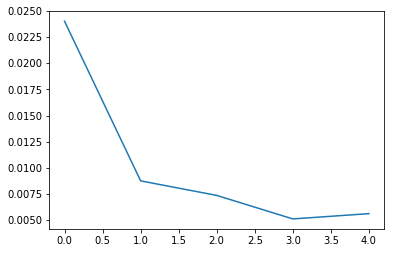

In [24]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

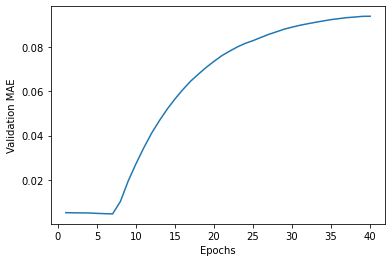

In [144]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(loss_per_epoch[5:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [145]:
# 10 history steps --> step 13
# last 10 points in train --> pt 1 in test data
first_eval_batch = scaled_train[-n_input:]

In [146]:
first_eval_batch

array([[0.85310387],
       [0.85925015],
       [0.83527966],
       [0.84019668],
       [0.84142594],
       [0.83036263],
       [0.83527966],
       [0.82544561],
       [0.81622618],
       [0.82360172],
       [0.84204057],
       [0.84695759],
       [0.86355255],
       [0.87277197],
       [0.87523049],
       [0.87215734],
       [0.84142594],
       [0.85617701],
       [0.85863553],
       [0.85494776],
       [0.83343577],
       [0.83589428],
       [0.83773817],
       [0.83036263],
       [0.83343577],
       [0.83896742],
       [0.85003073],
       [0.86662569],
       [0.87584511],
       [0.86785495],
       [0.85494776],
       [0.85679164],
       [0.84634296],
       [0.84265519],
       [0.85187462],
       [0.85248924],
       [0.82851875],
       [0.84265519],
       [0.84019668],
       [0.84142594],
       [0.83343577],
       [0.84204057],
       [0.83343577],
       [0.82360172],
       [0.82114321],
       [0.82544561],
       [0.82544561],
       [0.838

In [147]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))# make it 3 dimensional

In [148]:
model.predict(first_eval_batch)

array([[0.6102594]], dtype=float32)

In [149]:
scaled_test[0]

array([-0.09219422])

In [150]:
test_predictions = []

# last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]

# reshape this to the format RNN wants(same format as TimeSeries Generator)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

#how far into the future will I forecast?
#len(test) -->I can also change to 24

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [151]:
test_predictions

[array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=float32),
 array([0.6102594], dtype=fl

In [152]:
scaled_test

array([[-0.09219422],
       [-0.09219422],
       [-0.0983405 ],
       [-0.09649662],
       [-0.09403811],
       [-0.09403811],
       [-0.09280885],
       [-0.08973571],
       [-0.08666257],
       [-0.08543331],
       [-0.08481868],
       [-0.07682852],
       [-0.07375538],
       [-0.0633067 ],
       [-0.05285802],
       [-0.03995083],
       [-0.01843884],
       [ 0.00245851],
       [ 0.03749232],
       [ 0.07682852],
       [ 0.12169637],
       [ 0.15980332],
       [ 0.19913952],
       [ 0.22618316],
       [ 0.23847572],
       [ 0.23909035],
       [ 0.23724647],
       [ 0.23786109],
       [ 0.23724647],
       [ 0.23724647],
       [ 0.23724647],
       [ 0.23970498],
       [ 0.24093423],
       [ 0.23171481],
       [ 0.24093423],
       [ 0.24646589],
       [ 0.25138291],
       [ 0.24277812],
       [ 0.24277812],
       [ 0.244622  ],
       [ 0.24523663],
       [ 0.24708052],
       [ 0.25384143],
       [ 0.25691457],
       [ 0.26183159],
       [ 0

In [153]:
true_predictions = scaler.inverse_transform(test_predictions)

In [154]:
true_predictions

array([[1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.89206612],
       [1396.892

In [155]:
test['Predictions'] = true_predictions

<AxesSubplot:xlabel='WTI_Oil_Price'>

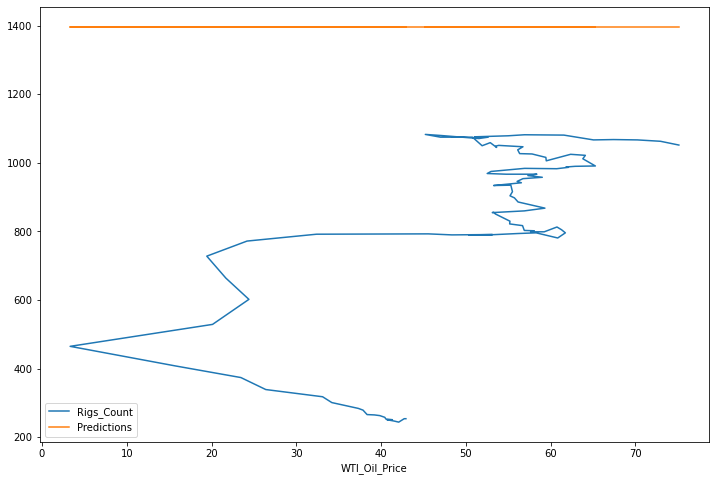

In [156]:
test.plot(figsize=(12,8))